# PyTASER DFT Workflow

In the following examples, we use the outputs from a density functional theory (DFT) calculation, from the [VASP](https://www.vasp.at) code, to generate the predicted absorption spectra under various conditions. Specifically, this requires the calculation of the orbital derivatives between electronic bands, which can be achieved using the `LOPTICS` `INCAR` tag in VASP (see [here](https://www.vasp.at/wiki/index.php/LOPTICS)).

**Note:**
To output the necessary information for `PyTASER` to compute the full absorption spectrum under various excitation conditions, the following tags must be set in the `INCAR` file:
```
LOPTICS = True  # calculate the frequency dependent dielectric matrix
LVEL = True  # output the full interband orbital derivative information to the WAVEDER
ISYM = 0  # turn off symmetry, currently required for parsing the WAVEDER with pymatgen
```

Alternatively, if only a single-point electronic structure calculation has been performed (i.e. with no `WAVEDER` output), we can still use the JDOS method as detailed below.

## Setup

In [ ]:
# Install package (if not done already)
!pip install git+https://github.com/WMD-group/PyTASER --quiet

## Parse Outputs

In [1]:
from pytaser.generator import TASGenerator

In [2]:
tg = TASGenerator.from_vasp_outputs("CdTe/k888_Optics/vasprun.xml", "CdTe/k888_Optics/WAVEDER")

In [3]:
tas = tg.generate_tas(energy_min=0, energy_max=7, temp=300, conc=1e21, cshift=1e-3)
# Note that we set cshift to a small value to avoid too much broadening of the spectrum
# If not set, this defaults to the value of `CSHIFT` used in the underlying VASP
# calculation (see docstrings for more info)

Calculating oscillator strengths (spin up, dark): 100%|██████████| 3900/3900 [00:00<00:00, 19835.00it/s]
Calculating oscillator strengths (spin up, under illumination): 100%|██████████| 3928/3928 [00:00<00:00, 20728.87it/s]


## Plotting

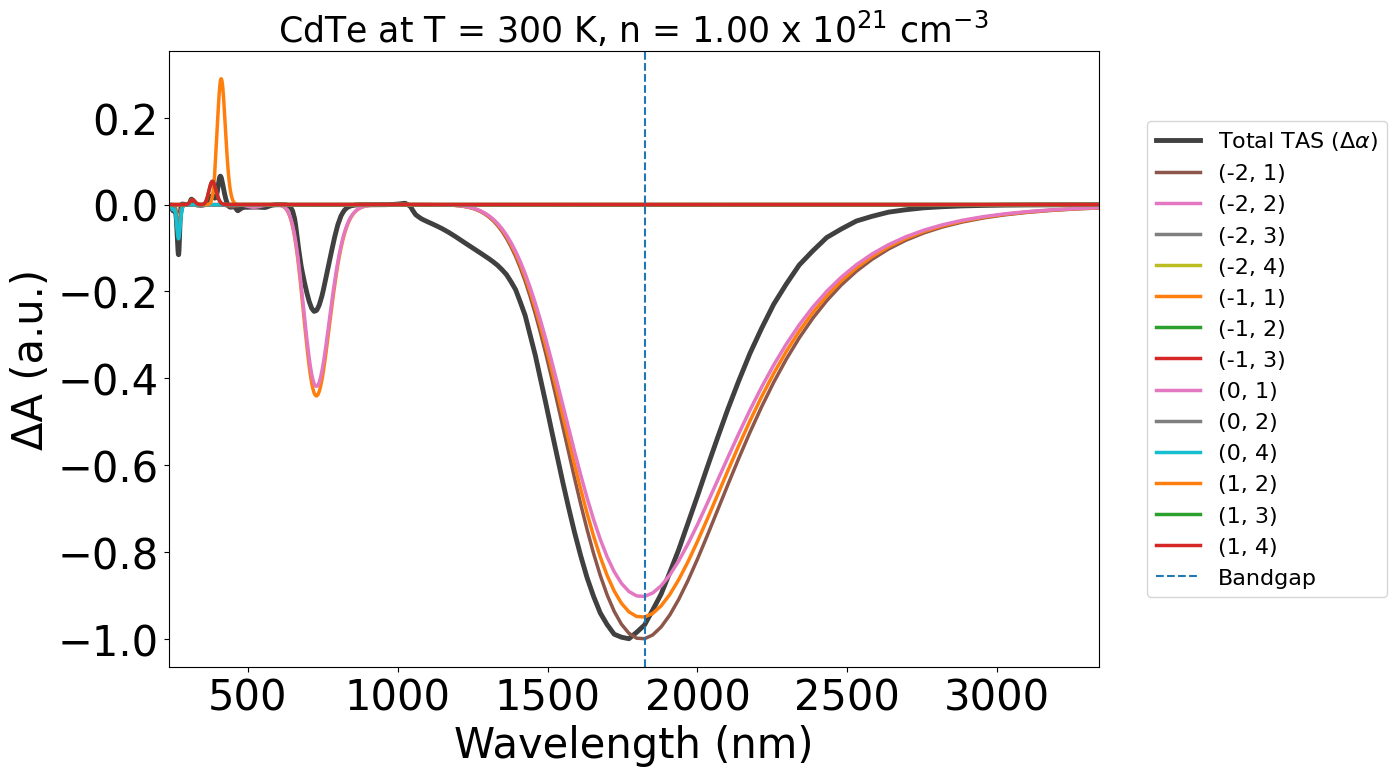

In [4]:
from pytaser.plotter import TASPlotter

plot_dft = TASPlotter(tas, material_name="CdTe")
energy_plot = plot_dft.get_plot()

```{note}
**Note:** 
In these plots, the labels `(-2,-1)` etc. refer to the band indices for the corresponding optical transition. The first being the initial band and the second being the final band in the electronic transition. 

Negative band indices refer to bands in the valence band (VBM as Band *#0*), and positive indices refer to bands in the conduction band (CBM as Band *#1*).
```

Let's plot with energy in eV as our x-axis, reduce our `transition_cutoff` to 0.01 and adjust the x-axis limits:
(There are many custom options available for plotting in `PyTASER`, see the docstrings/API for more details!)

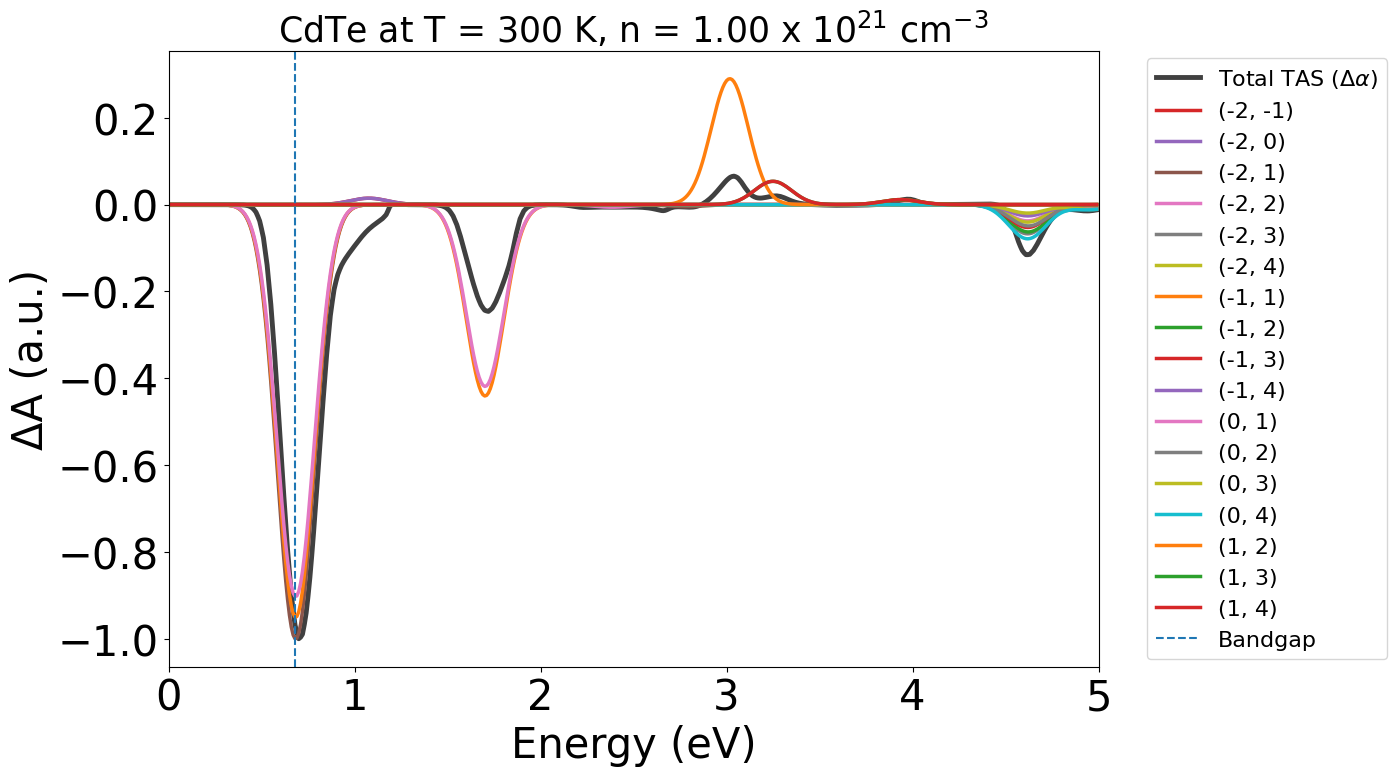

In [5]:
energy_plot = plot_dft.get_plot(xaxis="energy", transition_cutoff=0.01, xmin=0, xmax=5)

Here our VASP data is from a GGA PBE calculation, which is well-known to underestimate the experimental bandgap. As with the `Materials Project` data workflow in the other tutorial, we can apply a scissor operation to rigidly shift our electronic bands to match the experimental bandgap, like this:

In [6]:
shifted_tg = TASGenerator.from_vasp_outputs(
    "CdTe/k888_Optics/vasprun.xml",
    "CdTe/k888_Optics/WAVEDER",
    bg=1.5,  # CdTe room temp gap
)

In [7]:
shifted_tas = shifted_tg.generate_tas(energy_min=0, energy_max=7, temp=300, conc=1e22, cshift=1e-3)

Calculating oscillator strengths (spin up, dark): 100%|██████████| 3120/3120 [00:00<00:00, 19526.38it/s]
Calculating oscillator strengths (spin up, under illumination): 100%|██████████| 3145/3145 [00:00<00:00, 21506.31it/s]


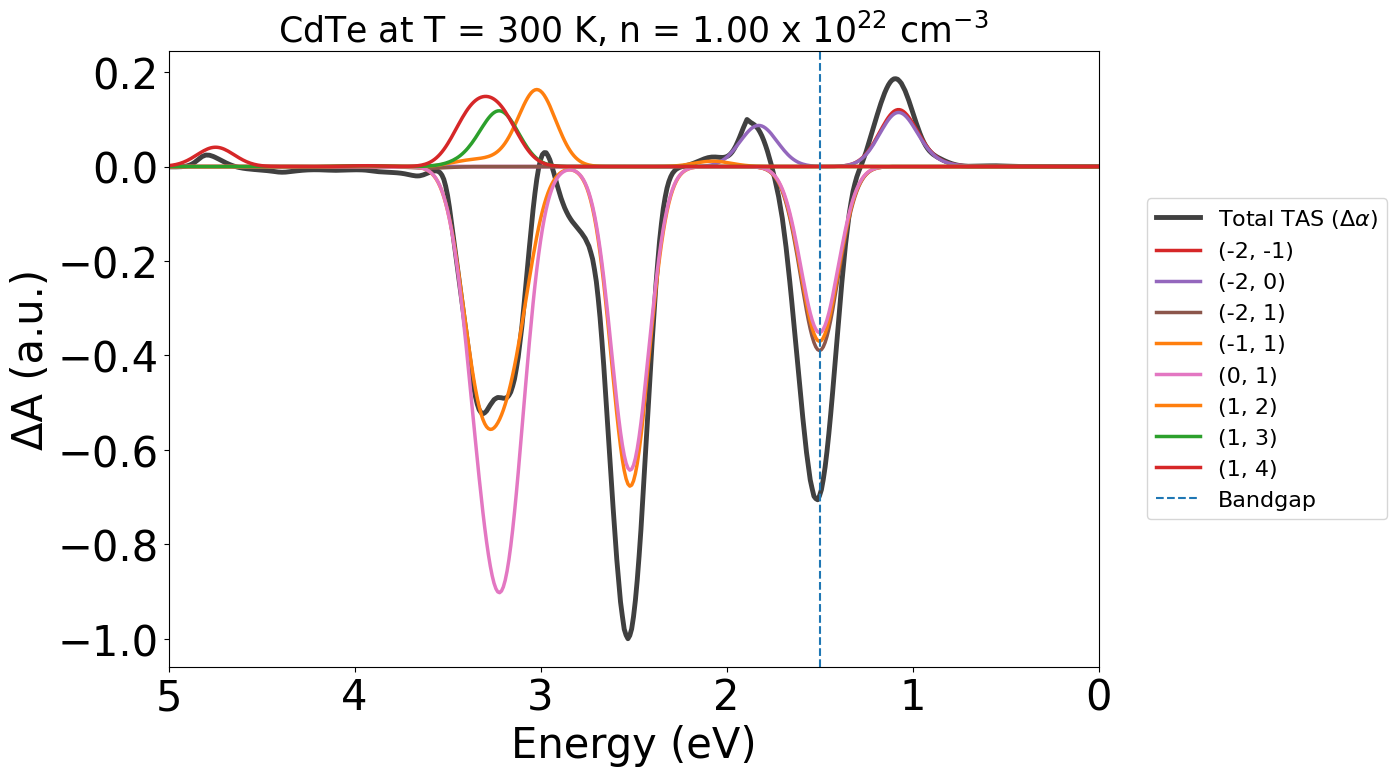

In [8]:
plot_dft = TASPlotter(shifted_tas, material_name="CdTe")
energy_plot = plot_dft.get_plot(
    xaxis="energy", transition_cutoff=0.01, xmin=0, xmax=5, yaxis="tas", invert_axis=True
)  # here we're inverting the x-axis for easier comparison to experiment

Here we can see our ground state bleach (GSB) peak has shifted to the bandgap value of 1.5 eV that we set.

### Plotting the Effective Absorption

We can also plot the predicted effective absorption in the dark and under illumination, by setting `yaxis="alpha"`:

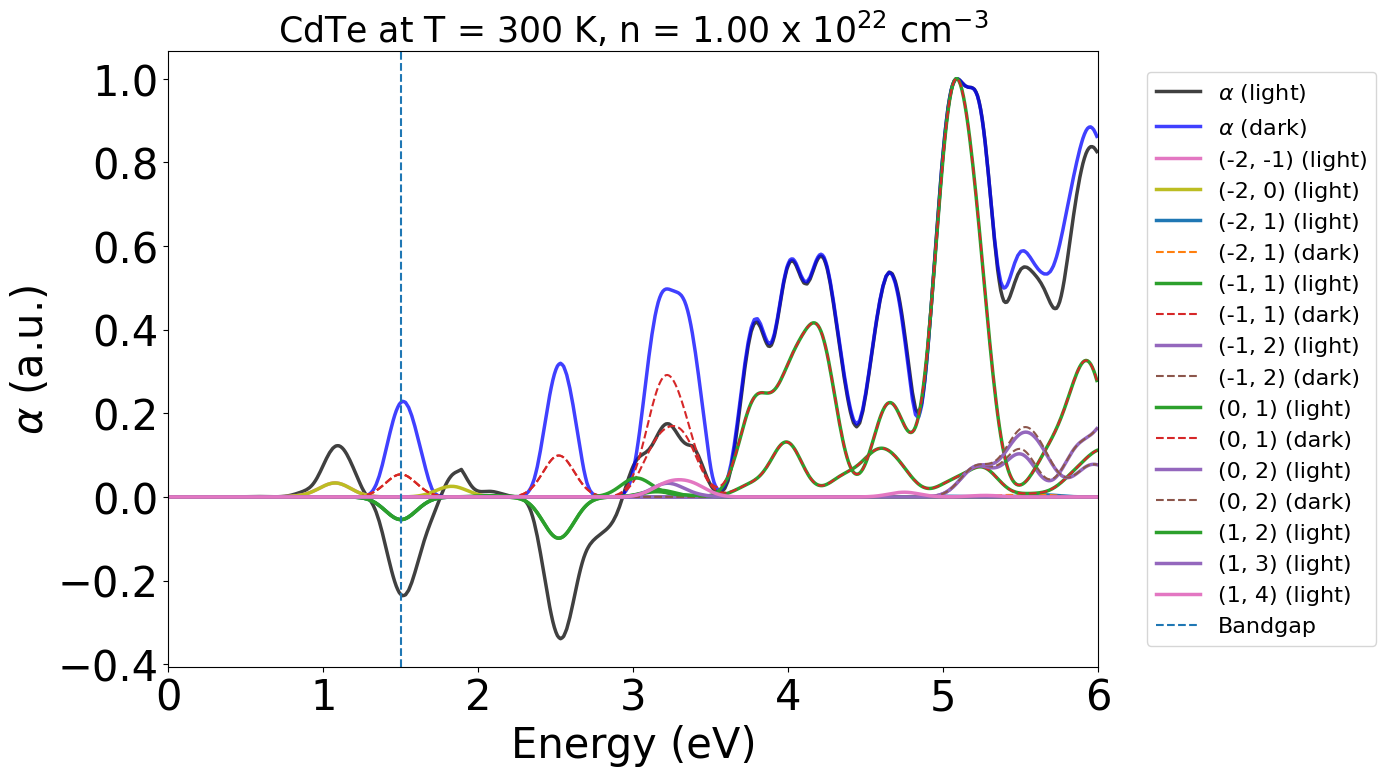

In [9]:
energy_plot = plot_dft.get_plot(xaxis="energy", xmin=0, xmax=6, transition_cutoff=0.01, yaxis="alpha")

We can see that under these conditions, we expect stimulated emission to occur at our bandgap energy (around 0.7 eV here), as we have population inversion at our VBM/CBM, with `ɑ (light)` being negative at this energy

### Plotting the Joint Density of States (JDOS)

Some other plotting options include the JDOS (in the dark and under illumination) with `yaxis="jdos"`, or the difference in JDOS between the dark and illuminated state with `yaxis="jdos_diff"`.

**Note:**
Additional keyword arguments provided to `get_plot()` are passed to `plt.legend()`, so you can use this to customise the plot legend as shown below (see [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)).

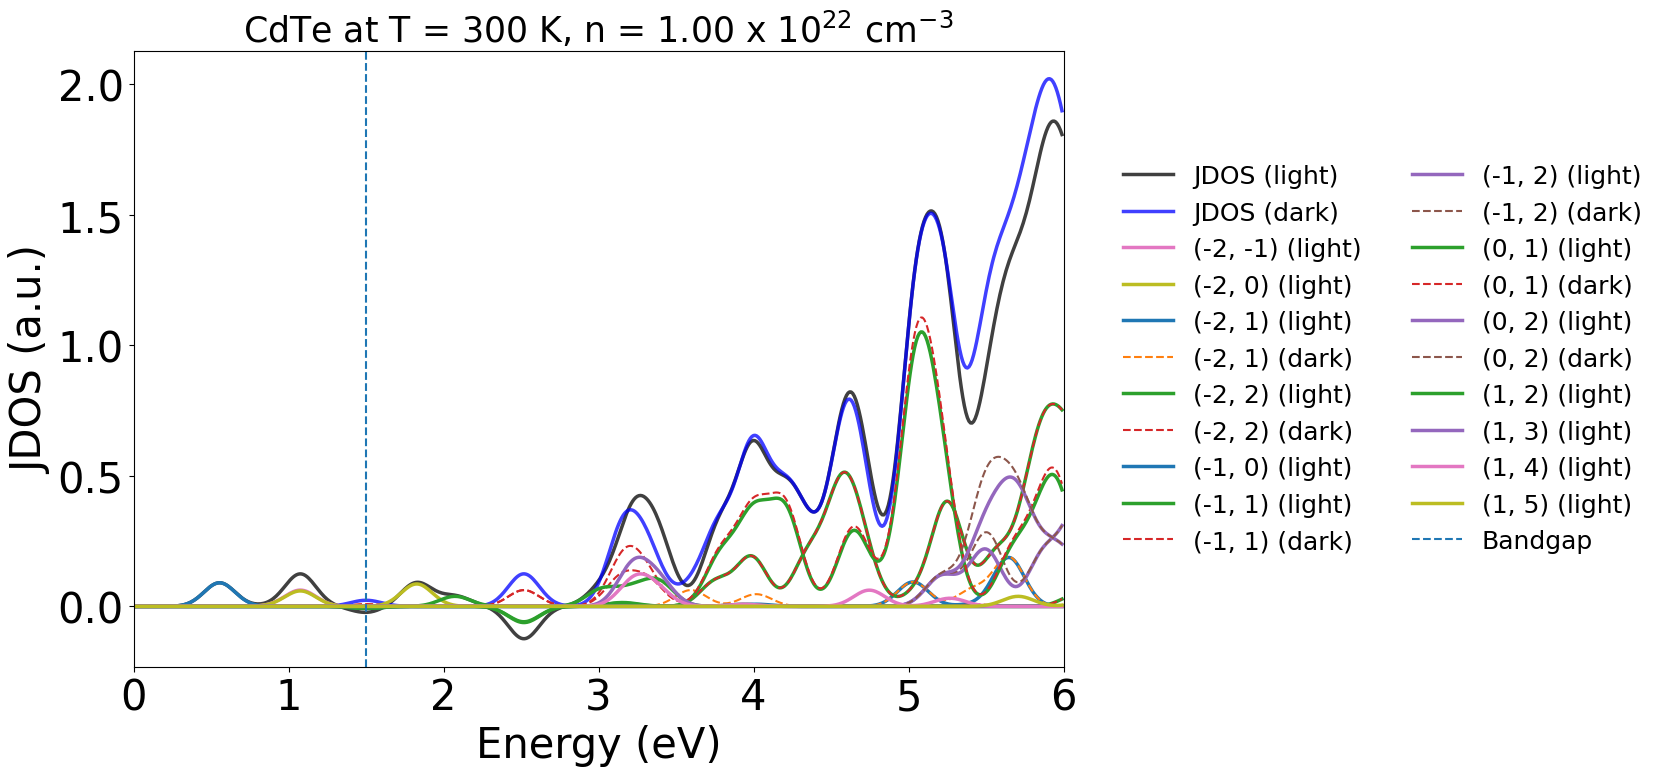

In [10]:
energy_plot = plot_dft.get_plot(
    xaxis="energy",
    transition_cutoff=0.01,
    yaxis="jdos",
    ncols=2,
    fontsize=18,
    frameon=False,
    xmin=0,
    xmax=6,
)

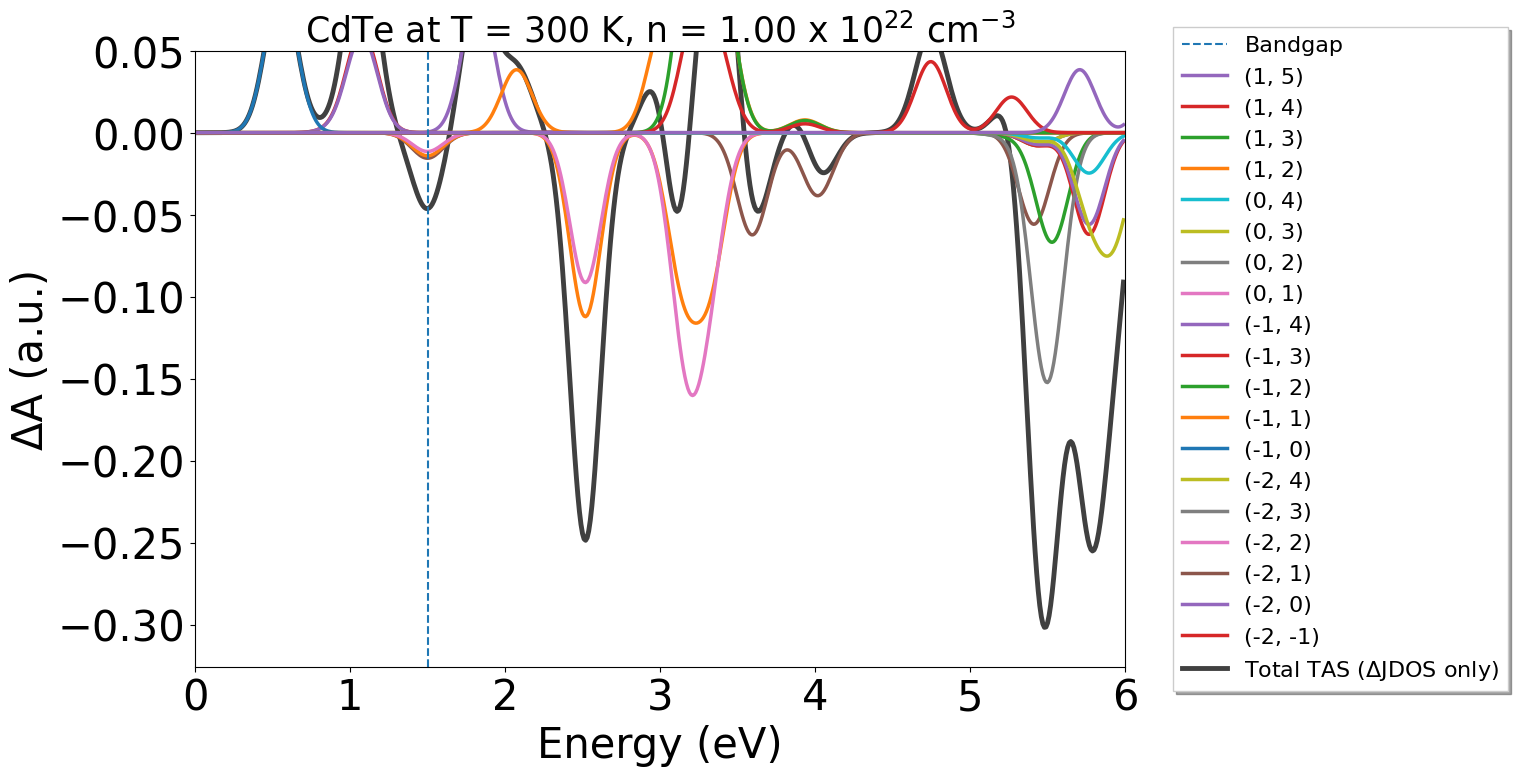

In [11]:
energy_plot = plot_dft.get_plot(
    xaxis="energy",
    transition_cutoff=0.01,
    yaxis="jdos_diff",
    reverse=True,
    fancybox=False,
    shadow=True,
    xmin=0,
    xmax=6,
    ymax=0.05,
)

## CH₃NH₃PbI₃ (MAPI) with spin-orbit coupling (SOC)

Let's look at another example of a tetragonal perovskite with a 4x4x3 k-point mesh and spin-orbit coupling (SOC). The dense k-point mesh along with low crystal symmetry (due to the organic molecule) and increase in bands due to SOC provides a computationally challenging case.

In [32]:
import wget  # download the files needed for the example

# if not already installed, you can install with `pip install wget`

wget.download(
    "https://github.com/WMD-group/PyTASER/releases/download/mapi_example/vasprun.xml.gz",
    "vasprun.xml.gz",
)
wget.download(
    "https://github.com/WMD-group/PyTASER/releases/download/mapi_example/WAVEDER",
    "WAVEDER",
);

In [12]:
tg = TASGenerator.from_vasp_outputs("vasprun.xml.gz", "WAVEDER")

/Users/kavanase/miniconda3/lib/python3.10/site-packages/pymatgen/io/vasp/outputs.py:138: UserWarning: Float overflow (*******) encountered in vasprun
  warnings.warn("Float overflow (*******) encountered in vasprun")


In [13]:
import time  # for timing the parsing

start = time.time()
tas = tg.generate_tas(temp=300, conc=1e22, cshift=1e-3)
print(f"Elapsed time: {time.time() - start:.2f} s")

Calculating oscillator strengths (spin up, dark): 100%|██████████| 261888/261888 [00:12<00:00, 21301.90it/s]
Calculating oscillator strengths (spin up, under illumination): 100%|██████████| 275006/275006 [00:13<00:00, 20832.30it/s]


Elapsed time: 121.42 s


Here we see that the parsing of the VASP outputs can take ~2 minutes to run, so it's a good idea to save the parsed data to a `json` file, so that we don't have to re-parse the data every time we want to re-run our analysis. We can do this using the `monty.serialization` functions (installed by default with `pymatgen`) as shown below:

In [14]:
from monty.serialization import dumpfn

dumpfn(tas, "MAPI_tas.json")

When we want to redo some of this analysis, in this notebook or a new one, we can now load the TAS object from the `json` file without having to re-parse the `WAVEDER` data, like this:

In [15]:
from monty.serialization import loadfn

tas = loadfn("MAPI_tas.json")

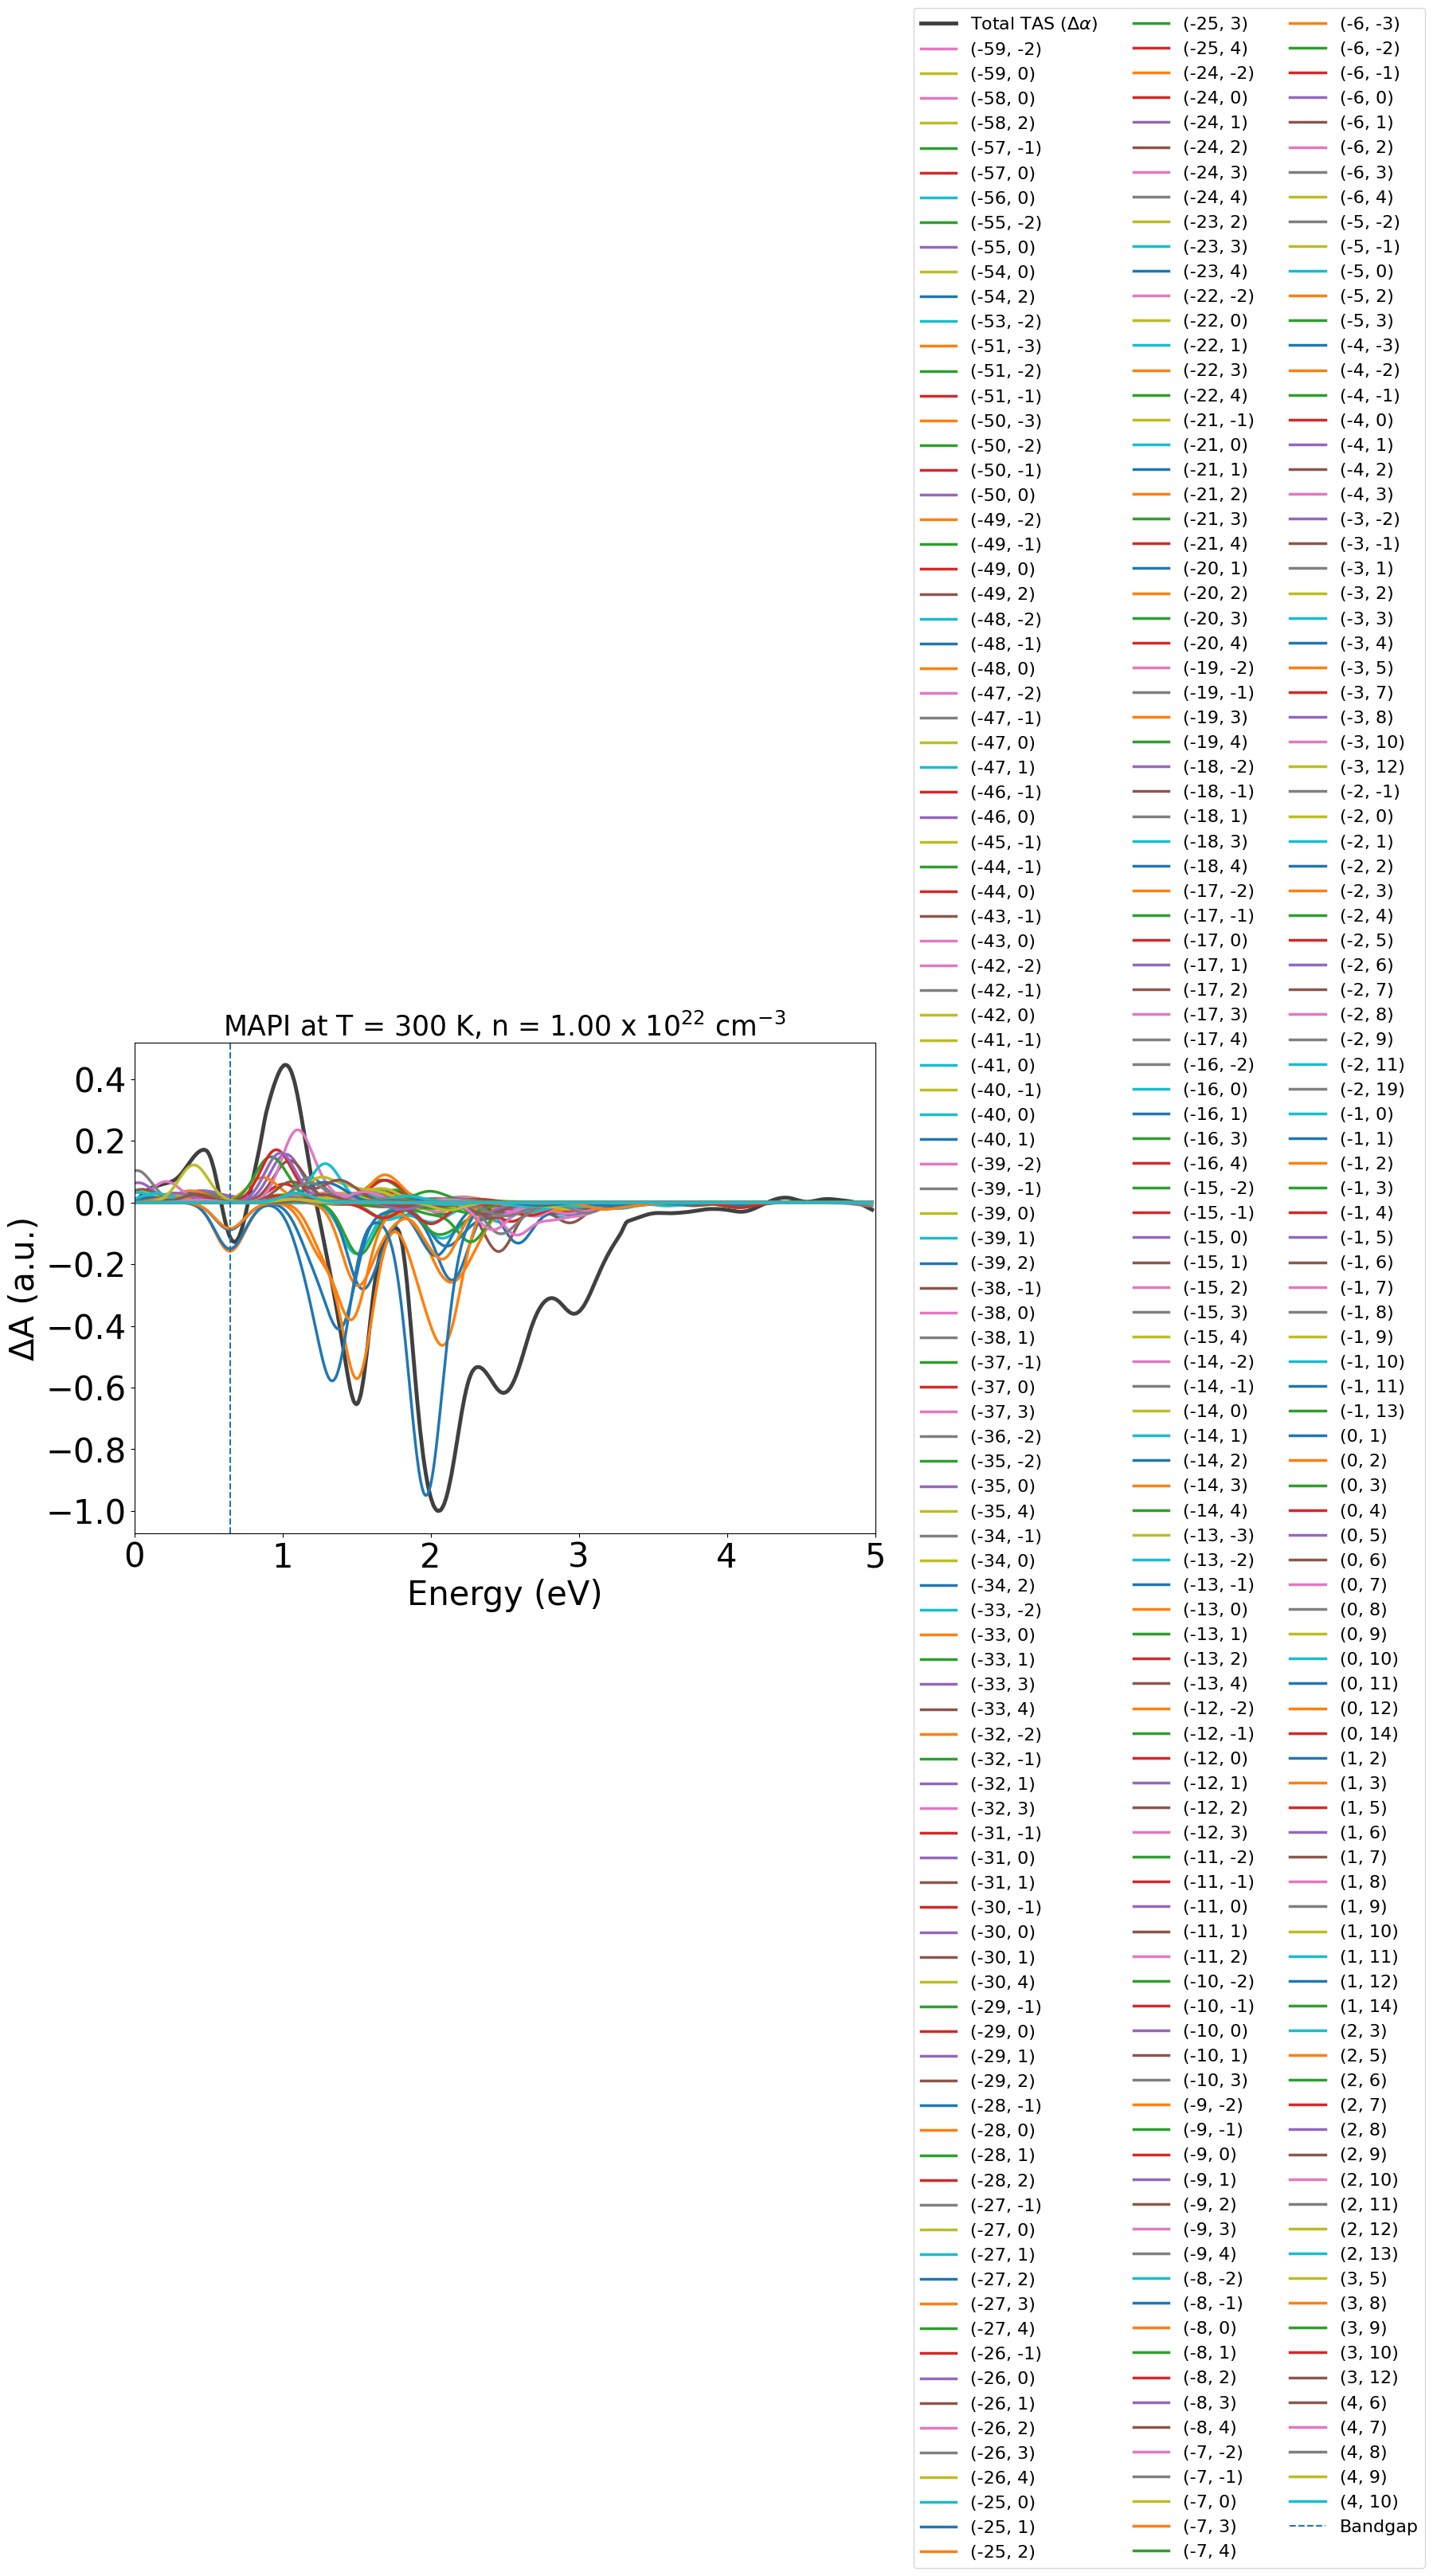

In [16]:
# plot the result:
plot_dft = TASPlotter(tas, material_name="MAPI")
energy_plot = plot_dft.get_plot(
    xaxis="energy",
    transition_cutoff=0.01,
    xmin=0,
    xmax=5,
    yaxis="tas",
    ncols=3,
)

Here due to the low symmetry of the _static_ perovskite structure and SOC splitting of the electronic bands, we end up with many contributing band-band transitions at low energies. We can reduce the plot legend to only name the strongest contributing transitions by adjusting `transition_cutoff`, and also setting `ncols` to make the legend easier to read:

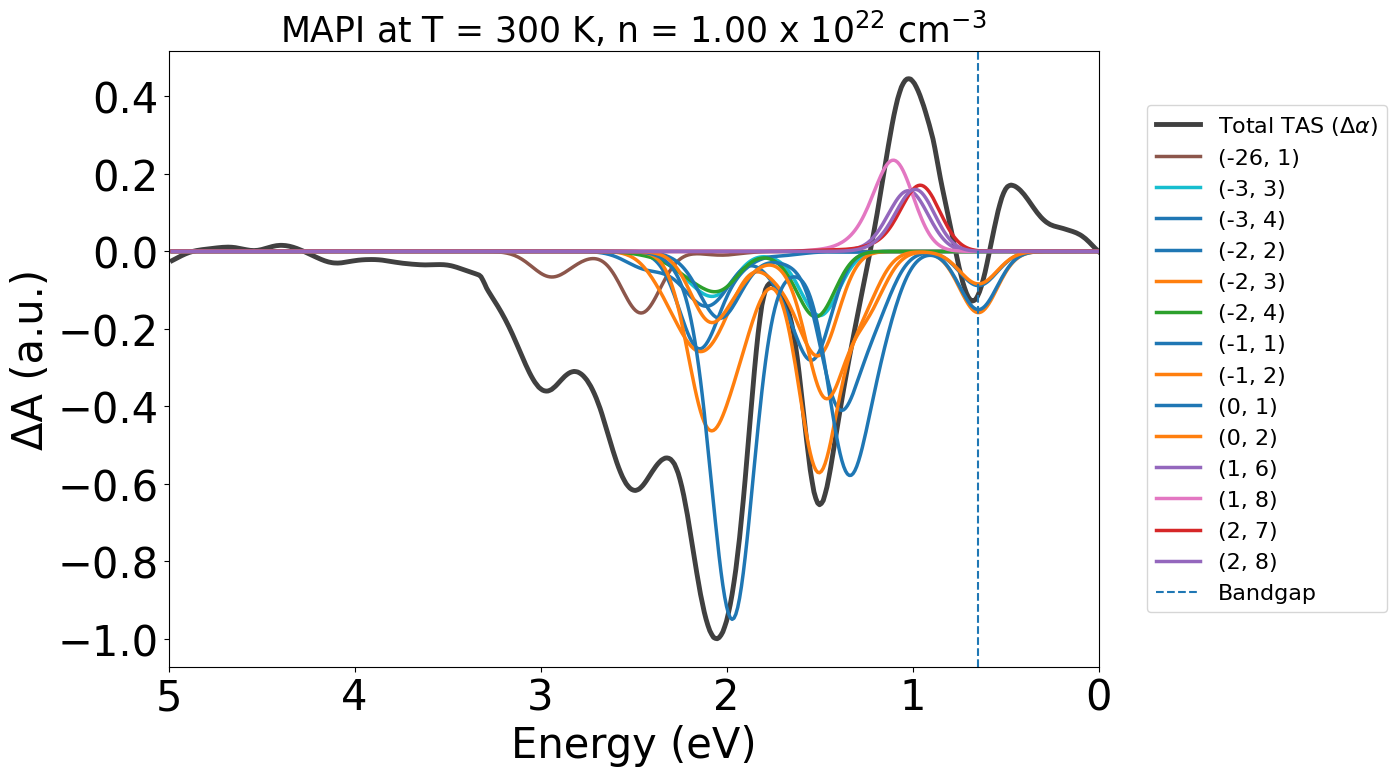

In [17]:
# plot the result:
plot_dft = TASPlotter(tas, material_name="MAPI")
energy_plot = plot_dft.get_plot(
    xaxis="energy",
    transition_cutoff=0.15,
    xmin=0,
    xmax=5,
    yaxis="tas",
    invert_axis=True,  # reverse the x-axis for easier comparison to experiment
)

Here we can see the dominant contribution is a large ground state bleach for the VBM -> CBM transition (`(0,1)`) in orange.

## Parse DFT Outputs (JDOS Only)

As mentioned above, if we've only performed a single-point electronic structure calculation with VASP, we can still plot the joint density of states in the dark, under illumination, and the difference between them.

In [18]:
from pytaser.generator import TASGenerator

In [19]:
tg = TASGenerator.from_vasp_outputs("CdTe/k666_Optics/vasprun.xml")  # No WAVEDER file this time

In [20]:
tas = tg.generate_tas(energy_min=0, energy_max=7, temp=300, conc=1e22)

In this case if we set `yaxis = "tas"`, it will use the difference in JDOS between the dark and illuminated state to generate an estimated TAS spectrum:

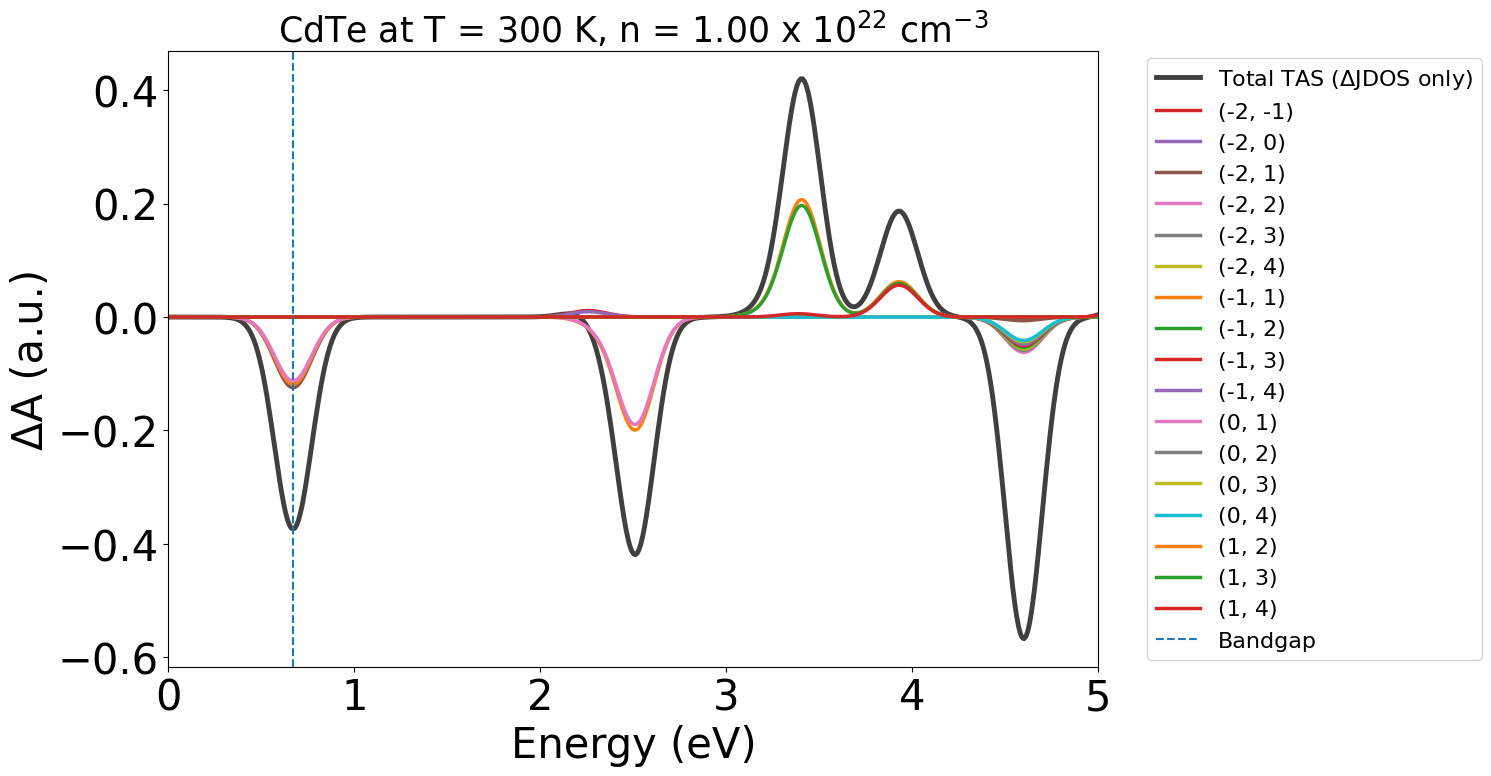

In [21]:
from pytaser.plotter import TASPlotter

plot_dft = TASPlotter(tas, material_name="CdTe")
energy_plot = plot_dft.get_plot(xaxis="energy", transition_cutoff=0.01, xmin=0, xmax=5, yaxis="tas")

Similarly, we can directly plot the JDOS in the dark and under illumination with `yaxis="jdos"`:

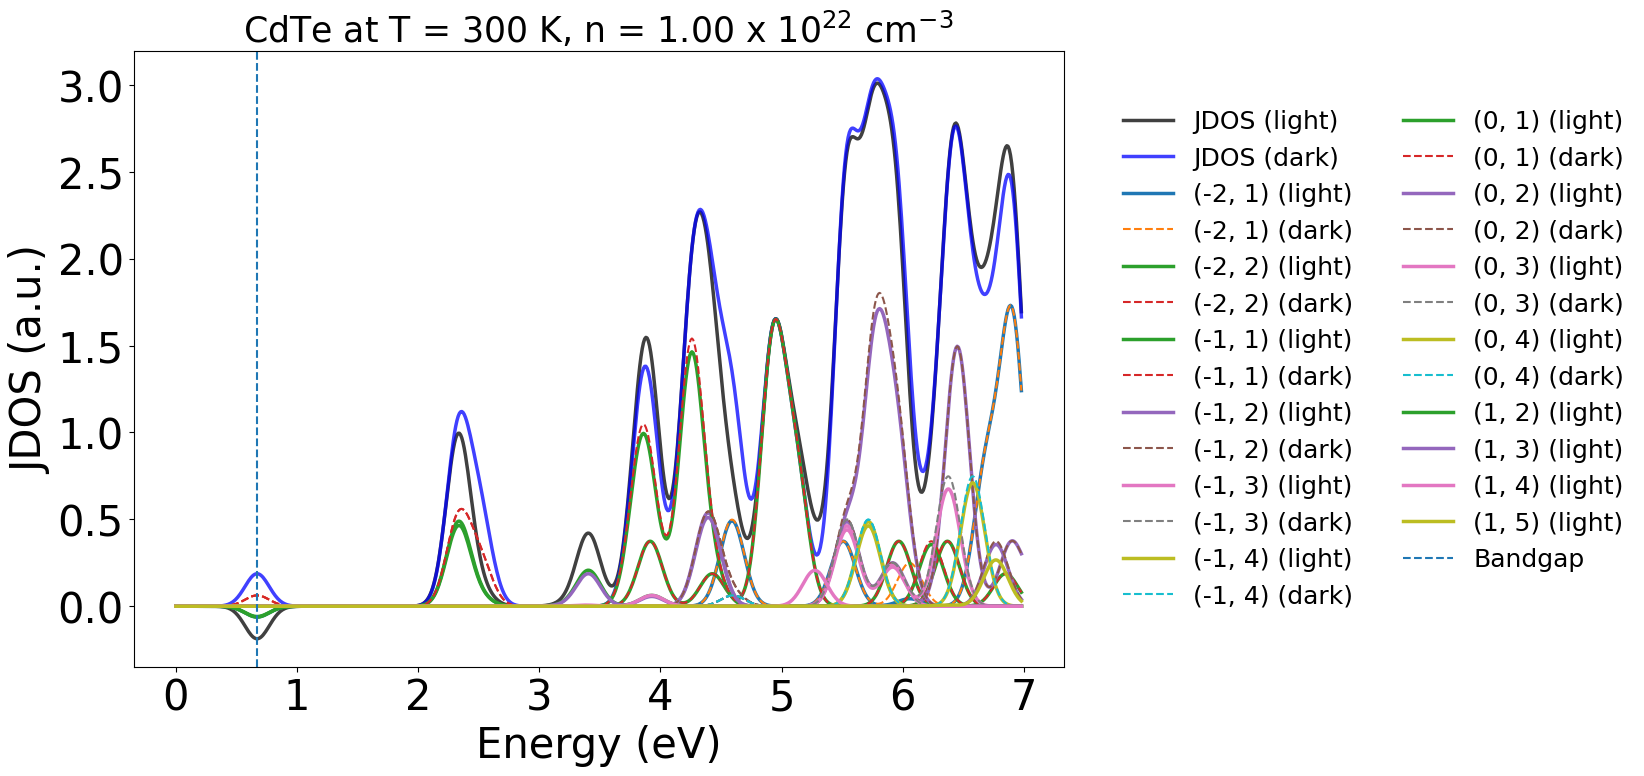

In [22]:
energy_plot = plot_dft.get_plot(
    xaxis="energy",
    transition_cutoff=0.01,
    yaxis="jdos",
    ncols=2,
    fontsize=18,
    frameon=False,
)

## Parse DFT Outputs (DAS)

Beyond TAS, we have also included a function to calculate a direct differential absorption spectrum (the 
difference between the ground-state optical absorption spectra of two systems). The DAS functionality can be used to represent any change in the environment of the system, such as de-lithiation, oxidations, etc.
There will certainly be cases where the inclusion of excitonic, thermal, and/or relativistic effects is necessary.
Here, we exemplify the DAS functionality by comparing the ground-state absorption spectra of monoclinic and 
tetragonal TiO$_{2}$.

Calculating oscillator strengths (spin up, dark): 100%|██████████| 104448/104448 [00:07<00:00, 14840.23it/s]


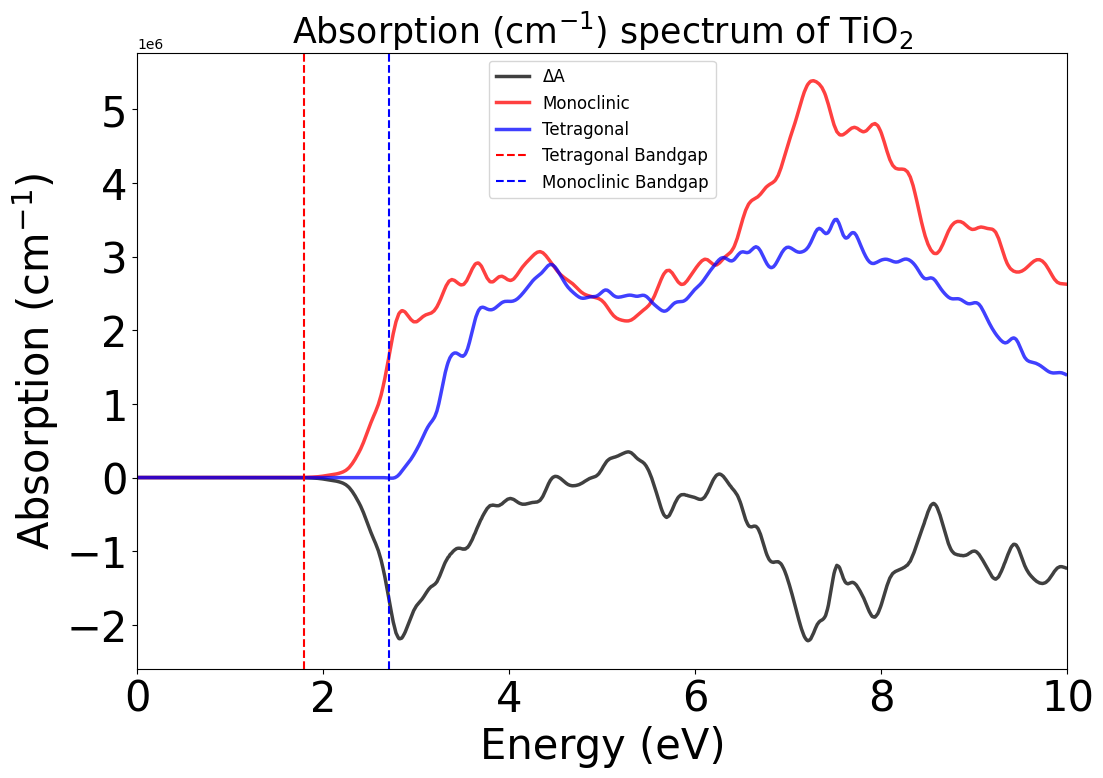

In [2]:
from pytaser.das_generator import DASGenerator
from pytaser.plotter import TASPlotter

# Note that we parse the system with the "change in the environment" first and the reference later.
# Similarly to TAS, one can parse the calculations with and without the WAVEDER file. If no
# WAVEDER file is found the code compares the JDOS of both systems.
tg = DASGenerator.from_vasp_outputs(
    "TiO2-DAS/mp554278-monoclinic/vasprun.xml",
    "TiO2-DAS/mp2657-tetragonal/vasprun.xml",
    "TiO2-DAS/mp554278-monoclinic/WAVEDER",
    "TiO2-DAS/mp2657-tetragonal/WAVEDER",
)

das = tg.generate_das(energy_min=0, energy_max=10, temp=300, cshift=1e-3, processes=1)


# In addition to the material_name, one can parse the system_name and reference_name for plotting purposes.
plot_dft = TASPlotter(
    das,
    material_name="TiO2",
    system_name="Monoclinic",
    reference_name="Tetragonal",
)
energy_plot = plot_dft.get_plot(xaxis="energy", transition_cutoff=0.01, xmin=0, xmax=10, yaxis="das")
# Reverse axis for better comparison to experiment
energy_plot.legend(loc="upper center", fontsize=12)
energy_plot.show()